# XML Parsing for PubMed Central

The representative code used to conduct XML parsing for articles in PubMed Central (PMC) to obtain title, abstract, and full body content in order to search for cooccurrence of drug and mutation related to HBV. Figures mentioned in sub-heading are making reference to the figure numbers in the report. 

In [1]:
from os import listdir
import os
import re
import glob
import xml.etree.ElementTree as ET
from PIL import Image

Figure 5 referred to in this Jupyter Notebook refers to the workflow below:

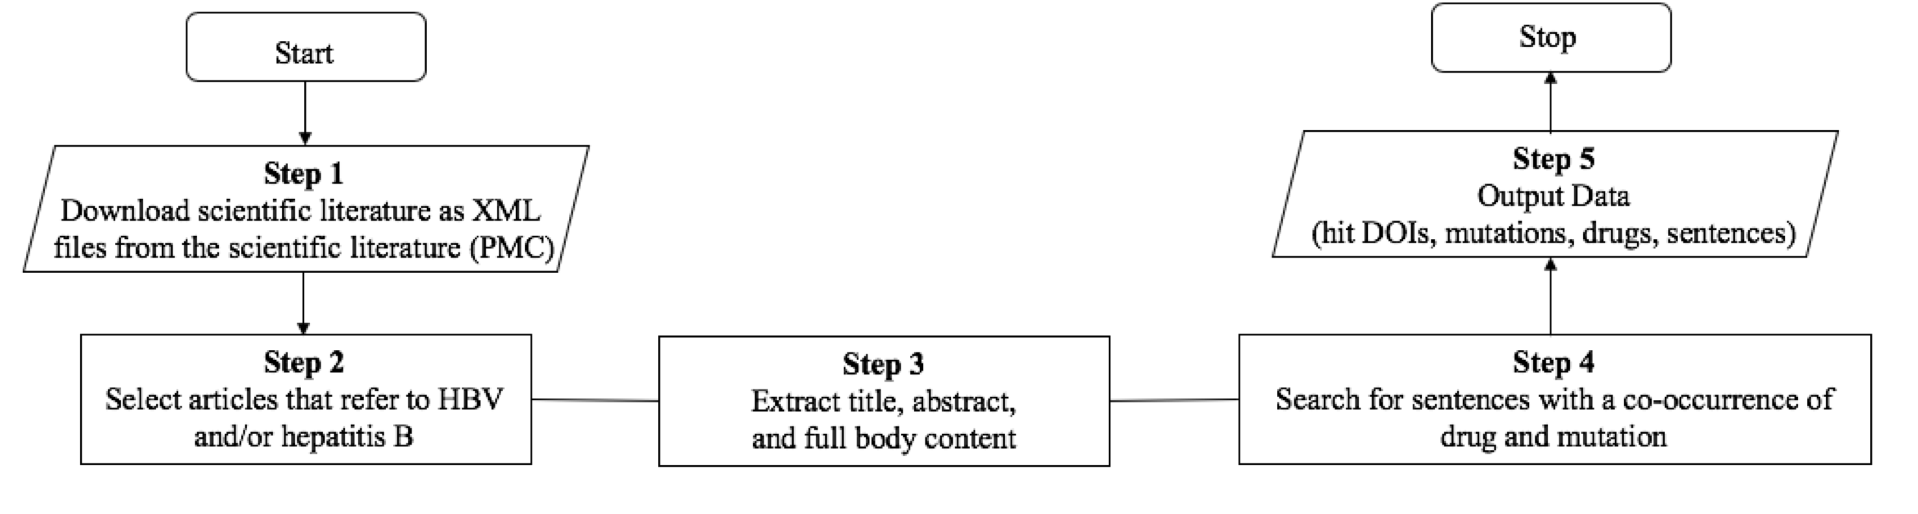

In [2]:
Image.open("./Figure5.png")

## Step 1 in Figure 5 (i.e. Download scientific literature as XML files from the scientific literature)

1. Download all files from ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_bulk/ and deposit inside your working directory. 
2. Unzip all tar.gz inside your working directory. 

## Step 2 in Figure 5 (i.e. Select articles that refer to HBV and/or Hepatitis B)

By using the command line arguments in Linux through GNU parallel:
1. Download GNU parallel (https://anaconda.org/conda-forge/parallel)
1. Select articles that refer to Hepatitis B by typing "find . -name '*.nxml' | parallel fgrep -i -l 'hepatitis b' {} > ./match_hepatitisB.txt" in the command line. This would place all the paths to the XML files that consisted of 'hepatitis b' (case insensitive) in the file content inside a text file called 'match_hepatitisB.txt' in the working directory.
2. Select articles that refer to HBV by typing "find . -name '*.nxml' | parallel fgrep -i -l 'hbv' {} > ./match_hbv.txt" in the command line. This would place all the paths to the XML files that consisted of 'hbv'  (case insensitive) in the file content inside a text file called 'match_hbv.txt' in the working directory.
3. Merge two text files from Steps 1 and 2 by typing "cat match*.txt > match_hbv_hepatitisB.txt" in the command line of the working directory.

Alternatively, you are able to conduct the same process by using the code shown below. 

In [ ]:
# Path to unzip directory for PubMed Central  (***modify to your own path)
path_to_PMC = glob.glob(
    "./PMC/unzip/*/")

In [ ]:
# Regular expression for HBV
search_hbv_regex = r"(?i)hbv"
# Regular expression for Hepatitis B
search_hepatitis_regex = r"(?i)hepatitis[ -]b"

In [ ]:
def files_match_search_hbv(path_to_PMC_directory, regex):
    files_match_search = set()
    for journal_name in path_to_PMC_directory:
        for filename in os.listdir(journal_name):
            if not filename.endswith('.nxml'):
                continue
            fullname = os.path.join(journal_name, filename)
            contents = open(fullname).read()
            matches = re.search(regex, contents)
            if matches:
                files_match_search.add(fullname)
    return(files_match_search)


def write_text_file(file_to_open, set_to_open):
    with open(file_to_open, 'w') as f:
        for item in set_to_open:
            f.write("%s\n" % item)

In [ ]:
# Find files that have the keyword 'hbv' in unzip directory for PubMed Central
file_match_search_hbv_path = files_match_search_hbv(path_to_PMC,
                                                    search_hbv_regex)

In [ ]:
# Write text file for files_match_search_hbv_path
write_text_file('./files_match_hbv_search.txt', file_match_search_hbv_path)

In [ ]:
# Find files that have the keyword 'hbv' in unzip directory for PubMed Central

file_match_search_hepatitis_path = files_match_search_hbv(
    path_to_PMC, search_hepatitis_regex)

In [ ]:
# Write text file for files_match_search_hepatitisb_path
write_text_file('./files_match_hepatitisb_search.txt',
                file_match_search_hepatitis_path)

After successfully generating files_match_hbv_search.txt and files_match_hepatitisb_search.txt inside your working directory, you are able to follow Step 3 described earlier using the Linux command line argument to merge two text files. 

## Steps 3-5 in Figure 5 (i.e. Extract title, abstract, and full body content; Search for co-occurrence of drug and mutation; Output Data (hit DOIs, mutations, sentences))

1. Create set of paths to access articles relevant to HBV and/or Hepatitis B from Step 2 in Figure 5

In [ ]:
# Create a new set called "match_hbv_hepatitisB_location"

match_hbv_hepatitisB_location = set()
#Change the path accordingly 
XML_files_contain_hbv_hepatitisB = open("./match_hbv_hepatitisB.txt", "r")

#Creates the set to open the XML file contents 
for file in XML_files_contain_hbv_hepatitisB:
    match_hbv_hepatitisB_location.add(file)

#Remove \n for each elements from the set
match_hbv_hepatitisB_location = map(lambda s: s.strip(), match_hbv_hepatitisB_location)
match_hbv_hepatitisB_location = set(match_hbv_hepatitisB_location)

2. Load the HBV drug vocabulary from DrugBank.ca (could be applied to any vocabulary that you wish to conduct XML parsing for)

In [ ]:
#Create set for pathways for drugbank_regex
drugbank_regex = set()
#Change the path accordingly 
file_drugbank_regex= open("./HBV_clinically_approved_DrugBank.txt", "r")

#Creates the set to open the regex file contents 
for file in file_drugbank_regex:
    drugbank_regex.add(file)

#Remove \n for each elements from the set
drugbank_regex = map(lambda s: s.strip(), drugbank_regex)
drugbank_regex = set(drugbank_regex)

3. Regular expressions for HBV (combined version of category 1-7) and splitting sentences. 

In [ ]:
mutation_patterns = r"(?i)(p\.|rt)?(?P<AA3wt>Ala|Arg|Asn|Asp|Asx|Cys|Glu|Gln|Glx|Gly|His|Ile|Leu|Lys|Met|Phe|Pro|Ser|Thr|Trp|Tyr|Val)(?P<POS>\d+)(?P<AA3mut>Ala|Arg|Asn|Asp|Asx|Cys|Glu|Gln|Glx|Gly|His|Ile|Leu|Lys|Met|Phe|Pro|Ser|Thr|Trp|Tyr|Val)|(c\.)?(?P<POS_C>\d+)(?P<AA1wt_C>[ARNDBCEQZGHILKMFPSTWYVO])>(?P<AA1mut_C>[ARNDBCEQZGHILKMFPSTWYVO])|(rt)?(?P<AA1wt>[ARNDBCEQZGHILKMFPSTWYVO])(?P<POS_1>\d+)(?P<AA1mut>[ARNDBCEQZGHILKMFPSTWYVO])"
regex_split = r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s"

In 4)-6), for ease of data processing, I have used the regular expression for each categories instead of the combination of all seven categories into one. Hence, mutation_patterns mentioned in 4)-6) above were replaced with regular expressions noted in Table 1 shown below (e.g. regex_base_Pos_base = r"(?i)(?P<base1>[AGTC])(?P<POS_1>\d+)(?P<base2>[GACT])" for mutation type 3).  

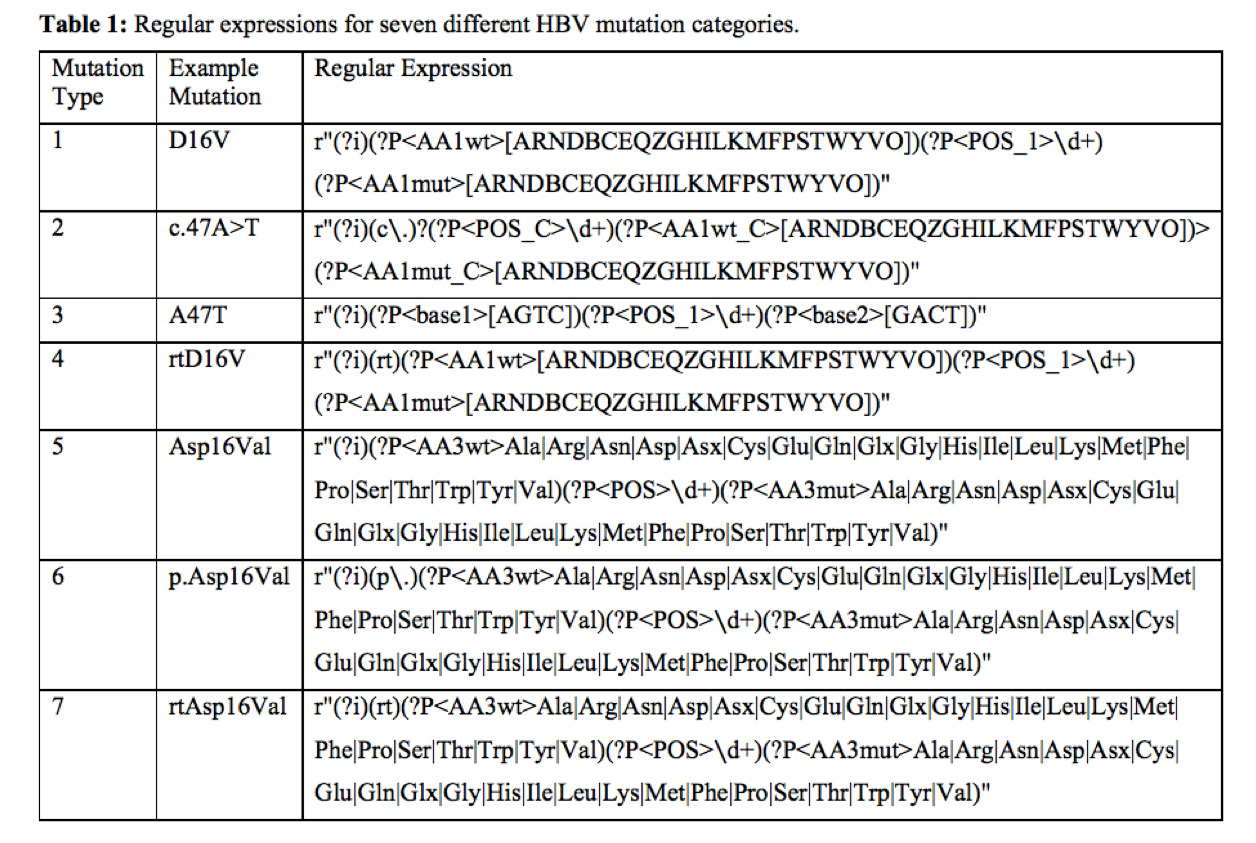

In [3]:
Image.open("./Table1.png")

In [ ]:
# Regex to create mutation subsets from PubMed Central
regex_AA1wt_Pos_AA1mut = r"(?i)(?P<AA1wt>[ARNDBCEQZGHILKMFPSTWYVO])(?P<POS_1>\d+)(?P<AA1mut>[ARNDBCEQZGHILKMFPSTWYVO])"
regex_base_Pos_base = r"(?i)(?P<base1>[AGTC])(?P<POS_1>\d+)(?P<base2>[GACT])"
regex_rt_AA1wt_Pos_AA1mut = r"(?i)(rt)(?P<AA1wt>[ARNDBCEQZGHILKMFPSTWYVO])(?P<POS_1>\d+)(?P<AA1mut>[ARNDBCEQZGHILKMFPSTWYVO])"
regex_c_Pos_AA1wt_AA1mut = r"(?i)(c\.)?(?P<POS_C>\d+)(?P<AA1wt_C>[ARNDBCEQZGHILKMFPSTWYVO])>(?P<AA1mut_C>[ARNDBCEQZGHILKMFPSTWYVO])"
regex_AA3wt_Pos_AA3mut = r"(?i)(?P<AA3wt>Ala|Arg|Asn|Asp|Asx|Cys|Glu|Gln|Glx|Gly|His|Ile|Leu|Lys|Met|Phe|Pro|Ser|Thr|Trp|Tyr|Val)(?P<POS>\d+)(?P<AA3mut>Ala|Arg|Asn|Asp|Asx|Cys|Glu|Gln|Glx|Gly|His|Ile|Leu|Lys|Met|Phe|Pro|Ser|Thr|Trp|Tyr|Val)"
regex_p_AA3wt_Pos_AA3mut = r"(?i)(p\.)(?P<AA3wt>Ala|Arg|Asn|Asp|Asx|Cys|Glu|Gln|Glx|Gly|His|Ile|Leu|Lys|Met|Phe|Pro|Ser|Thr|Trp|Tyr|Val)(?P<POS>\d+)(?P<AA3mut>Ala|Arg|Asn|Asp|Asx|Cys|Glu|Gln|Glx|Gly|His|Ile|Leu|Lys|Met|Phe|Pro|Ser|Thr|Trp|Tyr|Val)"
regex_rt_AA3wt_Pos_AA3mut = r"(?i)(rt)(?P<AA3wt>Ala|Arg|Asn|Asp|Asx|Cys|Glu|Gln|Glx|Gly|His|Ile|Leu|Lys|Met|Phe|Pro|Ser|Thr|Trp|Tyr|Val)(?P<POS>\d+)(?P<AA3mut>Ala|Arg|Asn|Asp|Asx|Cys|Glu|Gln|Glx|Gly|His|Ile|Leu|Lys|Met|Phe|Pro|Ser|Thr|Trp|Tyr|Val)"

4. Search for co-occurrence of drug and mutation whilst extracting for title from articles in 1)

In [ ]:
# Find content that matches the title
# then find HBV mutation patterns for files that satisfied drug filter

# set for title with cooccurrence of mutation and drug
cooccurrence_title_mutation = set()
# set for lines in title with cooccurrence of mutation and drug
cooccurrence_title_mutation_drug_line = set()
# set for DOI in title with cooccurrence of mutation and drug
cooccurrence_title_mutation_drug_location = set()
# set for drug in title with cooccurrence of mutation and drug
cooccurrence_title_mutation_drug = set()
# set of titles that match HBV drug vocabulary
title_match_drug = set()

for path_name in match_hbv_hepatitisB_location:
    # iterates over all articles related to HBV
    tree = ET.parse(path_name)
    root = tree.getroot()
    # keyword to search for title content in PubMed Central
    title = root.find('.//title-group/article-title')
    if title != None:
        title_match_bytes = ET.tostring(title)
        title_match_drug_string = title_match_bytes.decode()
        article_meta = root.find('.//article-meta')
        # keyword to search for DOIs
        doi = article_meta.find('article-id[@pub-id-type="doi"]')
        if doi != None:
            doi_match_bytes = ET.tostring(doi)
            path_name_doi = doi_match_bytes.decode()
            for drug in drugbank_regex:
                # searches whether a sentence mentions drug from drugbank_regex
                find_drug_patterns = re.search(drug, title_match_drug_string)
                if find_drug_patterns != None:
                    title_match_drug.add(title_match_drug_string)
                    for title_match_string in title_match_drug:
                        # searches whether a sentence that mentioned drug from drugbank_regex also mentions HBV-related mutation
                        find_mutation_patterns = re.search(mutation_patterns, title_match_string)
                        if find_mutation_patterns != None:
                            cooccurrence_title_mutation_drug_line.add(find_drug_patterns.group(0))
                            cooccurrence_title_mutation_drug.add(title_match_string)
                            cooccurrence_title_mutation.add(find_mutation_patterns.group(0))
                            cooccurrence_title_mutation_drug_location.add(path_name_doi)
                        else:
                            continue

5. Search for co-occurrence of drug and mutation whilst extracting for abstract from articles in 1)

In [ ]:
# set for abstract with cooccurrence of mutation and drug
cooccurrence_abstract_mutation = set()
# set for lines in abstract with cooccurrence of mutation and drug
cooccurrence_abstract_mutation_drug_line = set()
# set for DOI in abstract with cooccurrence of mutation and drug
cooccurrence_abstract_mutation_drug_location = set()
# set for drug in abstract with cooccurrence of mutation and drug
cooccurrence_abstract_mutation_drug = set()
# set of abstracts that match HBV drug vocabulary
abstract_match_drug = set()

for path_name in match_hbv_hepatitisB_location:
    # iterates over all articles related to HBV
    tree = ET.parse(path_name)
    root = tree.getroot()
    # keyword to search for abstract content in PubMed Central
    abstract = root.find('.//abstract')
    if abstract != None:
        abstract_match_bytes = ET.tostring(abstract)
        abstract_match_string = abstract_match_bytes.decode()
        article_meta = root.find('.//article-meta')
        # keyword to search for DOIs
        doi = article_meta.find('article-id[@pub-id-type="doi"]')
        if doi != None:
            doi_match_bytes = ET.tostring(doi)
            path_name_doi = doi_match_bytes.decode()
            # split texts into a sentence
            lines = re.split(regex_split, abstract_match_string)
            for line1 in lines:
                for drug in drugbank_regex:
                    #searches whether a sentence mentions drug from drugbank_regex
                    find_drug_patterns = re.search(drug, line1)
                    if find_drug_patterns != None:
                        abstract_match_drug.add(line1)
                        for line in abstract_match_drug:
                            #searches whether a sentence that mentioned drug from drugbank_regex also mentions HBV-related mutation
                            find_mutation_patterns = re.search(mutation_patterns, line)
                            if find_mutation_patterns != None:
                                cooccurrence_abstract_mutation.add(find_mutation_patterns.group(0))
                                cooccurrence_abstract_mutation_drug.add(find_drug_patterns.group(0))
                                cooccurrence_abstract_mutation_drug_location.add(path_name_doi)
                                cooccurrence_abstract_mutation_drug_line.add(line)
                            else:
                                continue

6. Search for co-occurrence of drug and mutation whilst extracting for full body content from articles in 1)

In [ ]:
# set for body content with cooccurrence of mutation and drug
cooccurrence_body_content_mutation = set()
# set for lines in body content with cooccurrence of mutation and drug
cooccurrence_body_content_mutation_drug_line = set()
# set for DOI in body content with cooccurrence of mutation and drug
cooccurrence_body_content_mutation_drug_location = set()
# set for drug in body content  with cooccurrence of mutation and drug
cooccurrence_body_content_mutation_drug = set()
# set of body contents that match HBV drug vocabulary
body_content_match_drug = set()

for path_name in match_hbv_hepatitisB_location:
    # iterates over all articles related to HBV
    tree = ET.parse(path_name)
    root = tree.getroot()
    # keyword to search for full body content in PubMed Central 
    body_content = root.find('.//body')
    if body_content != None:
        body_content_match_bytes = ET.tostring(body_content)
        body_content_match_string = body_content_match_bytes.decode()
        article_meta = root.find('.//article-meta')
        # keyword to search for DOIs
        doi = article_meta.find('article-id[@pub-id-type="doi"]')
        if doi != None:
            doi_match_bytes = ET.tostring(doi)
            path_name_doi = doi_match_bytes.decode()
            # split texts into a sentence
            lines = re.split(regex_split, body_content_match_string)
            for line1 in lines:
                for drug in drugbank_regex:
                    # searches whether a sentence mentions drug from drugbank_regex
                    find_drug_patterns = re.search(drug, line1)
                    if find_drug_patterns != None:
                        body_content_match_drug.add(line1)
                        for line in body_content_match_drug:
                            # searches whether a sentence that mentioned drug from drugbank_regex also mentions HBV-related mutation
                            find_mutation_patterns = re.search(mutation_patterns, line) 
                            if find_mutation_patterns != None:
                                cooccurrence_body_content_mutation.add(find_mutation_patterns.group(0))
                                cooccurrence_body_content_mutation_drug.add(find_drug_patterns.group(0))
                                cooccurrence_body_content_mutation_drug_location.add(path_name_doi)
                                cooccurrence_body_content_mutation_drug_line.add(line)
                            else:
                                continue